In [1]:
import pandas as pd
import ptitprince as pt
import numpy as np
import scipy.io
import scipy.stats as stats
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy.matlib
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM

In [2]:
selected_subjects = range(8,27)
excluded_subjects = [13, 14]
selected_subjects = list(set(selected_subjects).symmetric_difference(excluded_subjects))
number_of_subjects = len(selected_subjects)

In [3]:
root_directory = '..'
hemispheres = ['lh', 'rh']
regressors_of_interest = [
    'Stimulus_{Right,On}',
    'Stimulus_{Left,On}',
    'Stimulus_{Right,Off}',
    'Stimulus_{Left,Off}'
];

In [4]:
def make_figure(region):
    results = pd.DataFrame(columns=['Activation', 'Subject', 'Stimulus', 'Attention', 'Hemisphere', 'Area'])

    betas = {}
    betas['rh'] = np.zeros((number_of_subjects, len(regressors_of_interest)))
    betas['lh'] = np.zeros((number_of_subjects, len(regressors_of_interest)))
    for subject in range(len(selected_subjects)):
        for hemisphere in hemispheres:
            design_matrix = np.empty((0,0))
            regressors = []
            time_course = []
            for chunk in range(1,4):
                subject_directory = '{:s}\\SubjectData\\Subject{:02d}\\Set{:d}'.format(
                    root_directory, selected_subjects[subject], chunk
                )
                design_file = '{:s}\\DesignMatrix\\DesignStimulus.mat'.format(subject_directory);
                if not os.path.isfile(design_file):
                    continue

                mat = scipy.io.loadmat(design_file)
                d = mat['design']['DesignMatrix'][0,0]
                r = mat['design']['RegressorLabel'][0,0]
                design_matrix = np.concatenate((
                    np.concatenate((design_matrix, np.zeros((d.shape[0], design_matrix.shape[1]))), axis=0),
                    np.concatenate((np.zeros((design_matrix.shape[0], d.shape[1])), d), axis=0)),
                axis=1)
                regressors += [i[0][0] for i in np.transpose(r)]
                design_matrix = pd.DataFrame(data=design_matrix, columns=regressors)

                timecourse_file ='{:s}\\TimeCourses/{:s}.{:s}.mat'.format(
                    subject_directory, hemisphere, region
                )
                mat = scipy.io.loadmat(timecourse_file)
                time_course += [i[0] for i in mat['timeCourses']]

            time_course = np.concatenate((time_course), axis=1)
            model = LinearRegression(fit_intercept=False)
            model.fit(design_matrix, np.transpose(time_course))
            b = pd.DataFrame(model.coef_, columns=regressors)

            for regressor in range(len(regressors_of_interest)): 
                percent_signal_change = np.divide(b[regressors_of_interest[regressor]], b['Constant'])
                mean_over_runs = np.mean(percent_signal_change, 1)[0]
                betas[hemisphere][subject,regressor] += mean_over_runs


                if regressor == 0: # 'Stimulus_{Right,On}':
                    stimulus = 'On'
                    if hemisphere == 'lh':
                        attention = 'On'
                    else:
                        attention = 'Off'
                elif regressor == 1: # 'Stimulus_{Left,On}':
                    stimulus = 'On'
                    if hemisphere == 'lh':
                        attention = 'Off'
                    else:
                        attention = 'On'
                elif regressor == 2: #'Stimulus_{Right,Off}':
                    stimulus = 'Off'
                    if hemisphere == 'lh':
                        attention = 'On'
                    else:
                        attention = 'Off'
                elif regressor == 3: #'Stimulus_{Left,Off}':
                    stimulus = 'Off'
                    if hemisphere == 'lh':
                        attention = 'Off'
                    else:
                        attention = 'On'
                
                results = results.append({'Activation': betas[hemisphere][subject,regressor], 'Subject': subject, 'Stimulus': stimulus, 'Attention': attention, 'Hemisphere': hemisphere, 'Area': region}, ignore_index=True)
        
    return results

In [5]:
regions = ['V1', 'V2', 'V3']

group_results = pd.DataFrame()
betas = pd.DataFrame(columns=['Activation', 'Subject', 'Stimulus', 'Attention', 'Hemisphere', 'Area'])
for region in regions:
    a = make_figure(region)
    betas = betas.append(a)

aov_table = AnovaRM(betas, 'Activation', 'Subject', within=['Stimulus', 'Attention', 'Hemisphere', 'Area'])
res = aov_table.fit()
res.summary()

,F Value,Num DF,Den DF,Pr > F
Stimulus,335.5832,1.0000,16.0000,0.0000
Attention,121.2697,1.0000,16.0000,0.0000
Hemisphere,0.0883,1.0000,16.0000,0.7702
Area,35.9379,2.0000,32.0000,0.0000
Stimulus:Attention,6.6303,1.0000,16.0000,0.0204
Stimulus:Hemisphere,4.4755,1.0000,16.0000,0.0504
Attention:Hemisphere,0.6690,1.0000,16.0000,0.4254
Stimulus:Area,41.2176,2.0000,32.0000,0.0000
Attention:Area,0.7382,2.0000,32.0000,0.4859
Hemisphere:Area,1.0089,2.0000,32.0000,0.3759


In [6]:
betas["Task"] = betas["Stimulus"] + betas["Attention"]
# group by everything but hemisphere and take the the mean over that dimension
betas = betas.groupby(['Subject', 'Stimulus', 'Attention', 'Task', 'Area']).mean().reset_index()

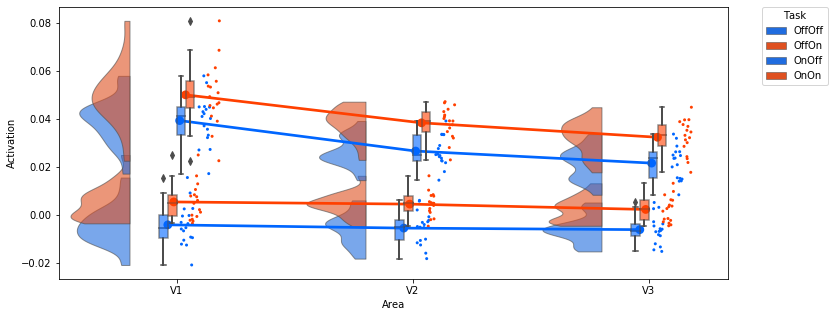

In [7]:
color_palletes = ["#0066ff", "#ff4000", "#0066ff", "#ff4000"]
dx   = "Area"
dy   = "Activation"
dhue = "Task"
pal  = sns.color_palette(color_palletes)

ax = pt.RainCloud(
    data       = betas, 
    x          = dx, 
    y          = dy,
    hue        = dhue, 
    palette    = pal, 
    bw         = .4, 
    width_viol = .5,
    figsize    = (12,5), 
    orient     = 'v' , 
    alpha      = .6, 
    dodge      = True, 
    pointplot  = True, 
    move       = 0.1    
)

### Attention effect per region:

In [8]:
attention_effect = pd.DataFrame(columns=['Region', 'Attention'])
for region in regions:
    effects = betas.query(f"Area == '{region}'").groupby(['Attention']).mean().reset_index()
    effect = effects.query(f"Attention == 'On'")["Activation"][1] - effects.query(f"Attention == 'Off'")["Activation"][0]
    attention_effect.loc[len(attention_effect)] = [region, effect]
attention_effect
# Add AMI -> aandacht / stimulus + literature (Somers 199X, Gandhi et al?)

,Region,Attention
0,V1,0.010145
1,V2,0.010894
2,V3,0.009606
